In [109]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

#from metpy.calc import relative_humidity_from_dewpoint
#from metpy.units import units
#relative_humidity_from_dewpoint(25 * units.degC, 12 * units.degC).to('percent')


In [110]:
def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

In [111]:
def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

In [112]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

In [113]:
def read_reanalysis():
    ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
    ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
    ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
    ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
    ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
    ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
    ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
    ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)
    t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'observed time to beginning of emergence']],
                    ds_d2m[[f'd2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']],
                            ds_tp[[f'tp at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
    ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
    return ds_reanalysis

In [114]:
def loc_and_SOS(ds_inputs, predictor_type = 'savgol'):
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    ds_inputs = dataset_fctns.get_station_locations(ds_inputs, station_data, check_lists = False)
    ds_inputs = dataset_fctns.add_SOS_to_df(ds_inputs)
    ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['year'], format = '%Y') + pd.to_timedelta(ds_inputs['SOS'], unit = 'D')
    if predictor_type == 'savgol' or predictor_type == 'thresholds_dates' or predictor_type == 'percentiles_dates':
        if predictor_type == 'savgol':
            date_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile']#'second last 75 percentile', 'last 75 percentile']
        elif predictor_type == 'thresholds_dates':
            date_columns = [f'first time crossing threshold {percent}%' for percent in range(100)] + [f'last time crossing threshold {percent}%' for percent in range(100)]
        elif predictor_type == 'percentiles_dates':
            date_columns = [f'first time crossing percentile {percent}%' for percent in range(100)] + [f'last time crossing percentile {percent}%' for percent in range(100)]
        elif predictor_type == 'MVI':
            date_columns = []
        for column in date_columns:
            ds_inputs[column] = pd.to_datetime(ds_inputs[column])
            ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
            ds_inputs[column] = ds_inputs[column].dt.days 
    return ds_inputs

In [118]:
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_Africa_t2m.csv')
ds_reanalysis = ds_reanalysis.drop('Unnamed: 0', axis = 1).rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_MODIS_SSA_WC_SOS.csv')
ds_LSP = ds_LSP.drop('Unnamed: 0', axis = 1)
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['WC SOS date'])
date_columns = ['mingrad', 'maxgrad', 
                'minday', 'maxday', 
                'first 50 percentile', 'last 50 percentile', 
                'first 90 percentile', 'last 90 percentile', 
                'observed time to beginning of flowering']
for column in date_columns:
    ds_inputs[column] = pd.to_datetime(ds_inputs[column])
    ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
    ds_inputs[column] = ds_inputs[column].dt.days 
                

In [115]:
ds_reanalysis_DE = read_reanalysis()
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_MODIS_DE.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol')
#ds_inputs = ds_inputs.rename(columns = {'first time crossing threshold 28%.1': 'first time crossing threshold 29%',
#                                        'first time crossing threshold 57%.1': 'first time crossing threshold 58%',
#                                        'last time crossing threshold 28%.1': 'last time crossing threshold 29%',
#                                        'last time crossing threshold 57%.1': 'last time crossing threshold 58%'})

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1580758913.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [22]:
ds_reanalysis_DE = read_reanalysis()
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_varied_percentiles3.csv')
ds_inputs_DE = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
#ds_inputs = ds_inputs.rename(columns = {'first time crossing threshold 28%.1': 'first time crossing threshold 29%',
#                                        'first time crossing threshold 57%.1': 'first time crossing threshold 58%',
#                                        'last time crossing threshold 28%.1': 'last time crossing threshold 29%',
#                                        'last time crossing threshold 57%.1': 'last time crossing threshold 58%'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='percentiles_dates')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1580758913.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [30]:
LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_MVI_MODIS_DE.csv')

In [119]:
def prepare_frame_for_ML(ds_inputs, phases, driver_variables, numdays = 200, predictor_type = 'savgol', cumulative = True, T_base = 6, temperature_type = 't2m'):
    phase_min_lengths = {'yellow ripeness': 50, 'beginning of flowering': 10, 'beginning of emergence': 0}
    ds_phase = ds_inputs.copy() #pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
    if temperature_type == 'model_output':
        temp_variable = f'modelled time to {phases[0]}'
    else:
        temp_variable = f'{temperature_type} at day 0'
    if predictor_type == 'savgol':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['mingrad', temp_variable], how='any')#, 'emergence date' 'NDVI interpolated at 2021-04-07'
    elif predictor_type == 'savgol_raw':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['mingrad', temp_variable], how='any')#'NDVI interpolated at 2021-04-07'
    elif predictor_type == 'thresholds':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['first time crossing threshold 0%', temp_variable], how='any')
    elif predictor_type == 'percentiles':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['first time crossing percentile 0%', temp_variable], how='any')
    elif predictor_type == 'linterp':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['linterp day 0', temp_variable], how='any')
    elif predictor_type == 'MVI':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['NDVI interpolated at day 04.03', temp_variable], how='any')
    #ds_ripeness = ds_ripeness.reset_index()#.drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
    if cumulative:
        ds_phase = make_cumulative(ds_phase, driver_variable = temperature_type, numdays = numdays, T_base = T_base)
    day_columns = [f'observed time to {phase}' for phase in phases]
    for column in day_columns:
        if isinstance(ds_phase[column].iloc[0], (np.timedelta64, str)):
            ds_phase[column] = pd.to_timedelta(ds_phase[column]).dt.days
    for phase in phases:
        ds_phase = ds_phase.where(ds_phase[f'observed time to {phase}'] > phase_min_lengths[phase]).dropna(how = 'all')
    return ds_phase

In [12]:
ds_flowering_KE

,year,Stations_Id,mingrad,maxgrad,minday,maxday,first 50 percentile,last 50 percentile,first 90 percentile,last 90 percentile,...,temperature at day 291,temperature at day 292,temperature at day 293,temperature at day 294,temperature at day 295,temperature at day 296,temperature at day 297,temperature at day 298,temperature at day 299,observed time to beginning of flowering
5,2004,7.0,159,-25,199,31,103,143,23,55,...,21.285382,21.076642,21.046497,21.921490,20.650732,21.572260,21.917664,21.305219,22.083203,65
6,2005,7.0,121,-79,153,73,-63,113,65,89,...,21.047375,21.922107,21.743152,21.299823,20.334180,21.777515,21.992346,21.797272,21.612866,74
13,2004,8.0,150,-42,190,54,-2,142,38,62,...,20.633066,21.581432,21.902982,22.315938,21.828328,21.880244,21.628464,21.057153,20.671897,70
14,2005,8.0,117,-35,149,69,-27,101,53,85,...,20.627688,20.961022,20.877188,20.909591,20.996335,21.027358,20.872086,20.068140,21.053615,67
18,2001,9.0,138,-54,-54,82,10,138,82,130,...,19.990269,20.942594,21.984928,22.071531,21.905123,22.043108,22.135822,22.510162,21.356929,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,2001,1063.0,149,-19,173,125,5,157,125,141,...,18.111053,17.716125,18.079895,19.531555,20.955658,22.748688,23.618622,23.130005,22.844666,71
783,2003,1063.0,55,111,7,135,31,175,39,143,...,16.140961,16.256622,17.855591,19.910278,21.519226,22.894714,23.370605,20.108521,19.019653,66
790,2003,1064.0,151,39,175,103,39,143,71,119,...,16.136163,16.278954,17.875586,19.909399,21.491255,22.871204,23.420066,20.149082,19.001401,130
793,2006,1064.0,115,-13,-37,91,3,123,83,99,...,22.795397,24.321079,23.700048,22.143767,21.204370,21.401970,21.788479,19.496946,19.009674,68


In [120]:
#ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'savgol', T_base = 6)#, cumulative=False)
ds_flowering_KE = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'savgol', temperature_type='temperature')#, cumulative=False)
#ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'savgol')#, cumulative=False)

In [121]:
ds_ripeness_DE_savgol = prepare_frame_for_ML(ds_inputs_DE, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'savgol', temperature_type='t2m')#, cumulative=False)
ds_flowering_DE_savgol = prepare_frame_for_ML(ds_inputs_DE, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'savgol', temperature_type='t2m')#, cumulative=False)
ds_emergence_DE_savgol = prepare_frame_for_ML(ds_inputs_DE, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'savgol', temperature_type='t2m')#, cumulative=False)

In [88]:
ds_ripeness_DE = prepare_frame_for_ML(ds_inputs_DE, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'percentiles', T_base = 6, temperature_type='t2m')#, cumulative=False)
ds_flowering_DE = prepare_frame_for_ML(ds_inputs_DE, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'percentiles', temperature_type='t2m')#, cumulative=False)
ds_emergence_DE = prepare_frame_for_ML(ds_inputs_DE, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'percentiles', temperature_type='t2m')#, cumulative=False)

In [87]:
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'thresholds', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'thresholds')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'thresholds')#, cumulative=False)

In [132]:
def train_and_run_tree(ds, 
                       phase_list = ['yellow ripeness'],
                       training_columns =  [f't2m at day {n}' for n in range(200)],
                       response_columns =['observed time to yellow ripeness']):
    train, test = train_test_split(ds, test_size=0.2, random_state = 1)
    #clf = GradientBoostingRegressor(
    #    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    #    loss='squared_error'
    #)
    clf = RandomForestRegressor()#max_depth=3, random_state=0, min_samples_leaf=1)
    X_training = train[training_columns].values
    y_training = train[response_columns].values.ravel()
    X_eval = test[training_columns].values
    y_eval = test[response_columns].values.ravel()
    clf_fit = clf.fit(X_training, y_training)
    for phase_index, phase in enumerate(phase_list):
        train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
        test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
        train[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
        test[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
    test['train_test'] = 'test'
    train['train_test'] = 'train'
    ds_results = pd.concat([test, train], axis=0)
    return test, train, clf_fit

In [124]:
def apply_tree_new_data(ds, clf_fit,
                       phase_list = ['yellow ripeness'],
                       training_columns =  [f't2m at day {n}' for n in range(200)],
                       response_columns =['observed time to yellow ripeness']):
    X_eval = ds[training_columns].values
    y_eval = ds[response_columns].values.ravel()
    for phase_index, phase in enumerate(phase_list):
        ds.loc[:, f'RF to {phase}'] = clf_flowering_DE.predict(X_eval)#[phase_index]#:, 
        ds[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
    ds['train_test'] = 'test'
    return ds

In [125]:
def plot_modelled_observed(ds, phase_list = ['yellow ripeness'], font_size = 20):
    for phase in phase_list:
        fig, axs = plt.subplots(1, len(phase_list), figsize = (len(phase_list)*5, 5))
        minval = min(ds[f'observed time to {phase}'].min(), ds[f'RF to {phase}'].min()) - 1
        maxval = max(ds[f'observed time to {phase}'].max(), ds[f'RF to {phase}'].max()) + 1
        sns.regplot(x=f'RF to {phase}', y=f'observed time to {phase}', data=ds, ax=axs,
                    scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
        axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
        axs.set_xlim(minval, maxval)
        axs.set_ylim(minval, maxval)
        axs.set_title(f'Comparison of modelled and observed time to {phase}')
        rsquared = r2_score(ds[f'observed time to {phase}'], ds[f'RF to {phase}'])
        print(f'R^2 value for model: {rsquared}')
        bias = ds[f'observed time to {phase}'].mean() - ds[f'RF to {phase}'].mean()
        variance_modelled = ds[f'RF to {phase}'].var()
        print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.17257528137780753
Bias: 0.00046131481352917414
Variance of modelled values: 40.41227308309016


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3892583840635073
Bias: 0.013546641758918858
Variance of modelled values: 51.55697522450632


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3754474513765722
Bias: 0.011670274702572826
Variance of modelled values: 53.718858481638364


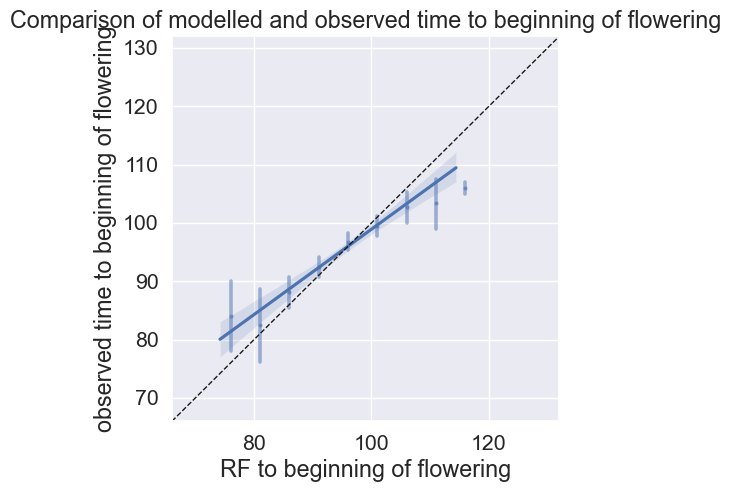

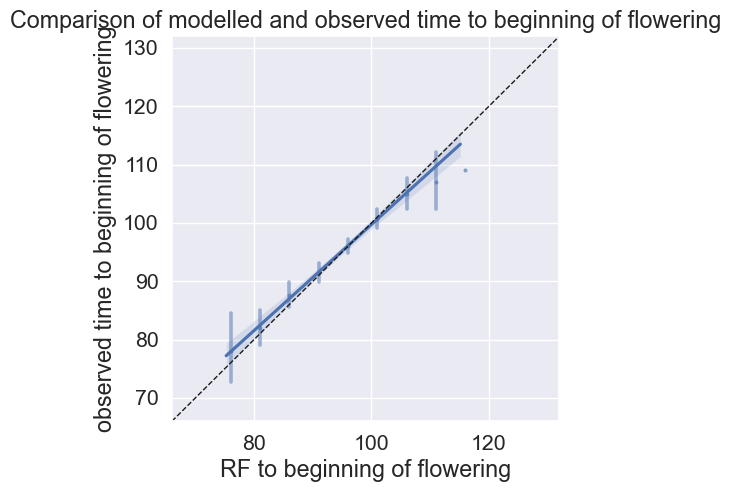

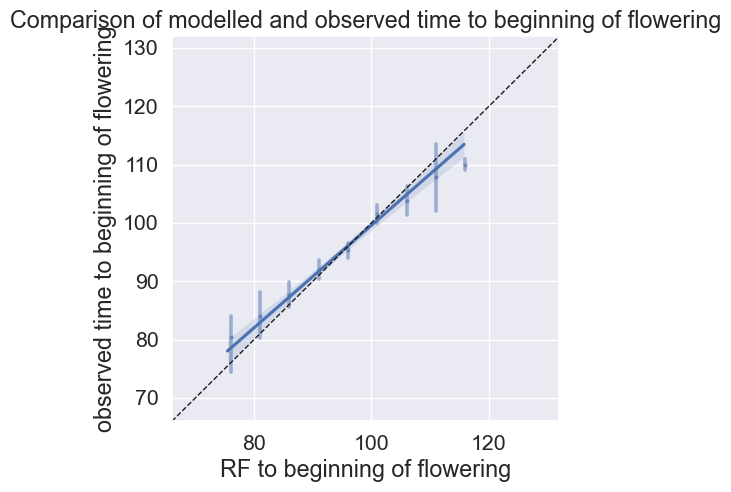

In [126]:
test_flowering_DE, train_flowering_DE, clf_flowering_DE = train_and_run_tree(ds_flowering_DE_savgol,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],#[f't2m at day {n}' for n in range(200)],# + 
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_DE, phase_list = ['beginning of flowering'])
test_flowering_DE, train_flowering_DE, clf_flowering_DE = train_and_run_tree(ds_flowering_DE_savgol,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'] + [f't2m at day {n}' for n in range(200)],# + 
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_DE, phase_list = ['beginning of flowering'])
test_flowering_DE, train_flowering_DE, clf_flowering_DE = train_and_run_tree(ds_flowering_DE_savgol,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],# + 
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_DE, phase_list = ['beginning of flowering'])


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.2402945489831504
Bias: 0.05443005356637087
Variance of modelled values: 81.177919429899


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.4916741571208558
Bias: 0.09682671689388542
Variance of modelled values: 96.84440607366844


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1424\1156102702.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.4884948509643475
Bias: 0.06450751002863989
Variance of modelled values: 96.58201577784354


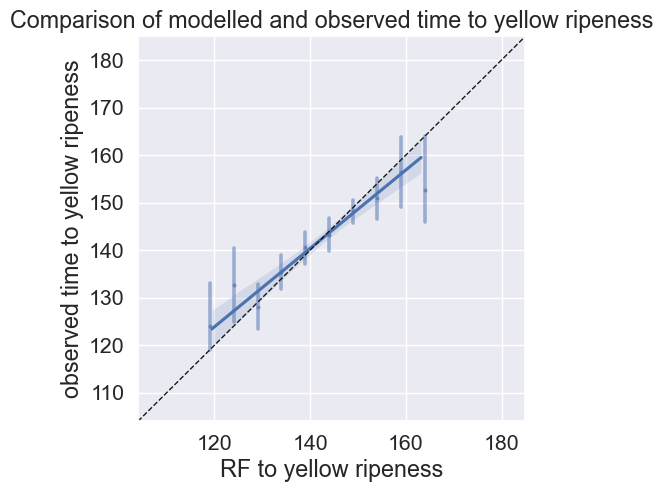

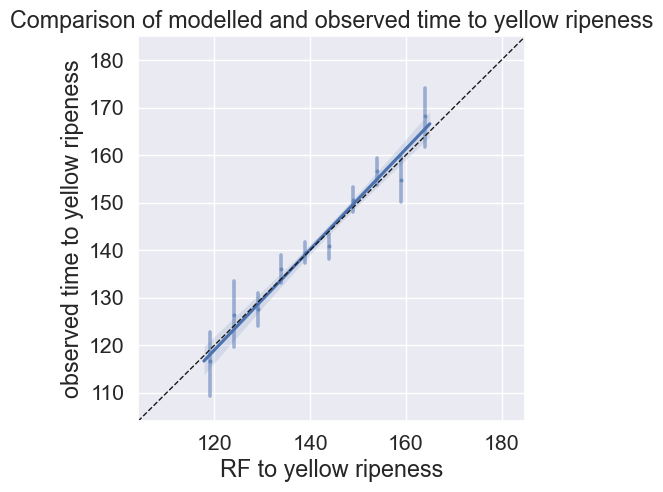

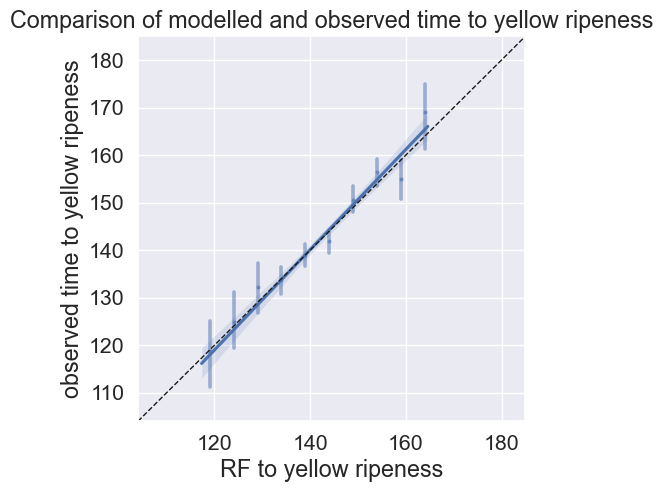

In [129]:
test_ripeness_DE, train_ripeness_DE, clf_ripeness_DE = train_and_run_tree(ds_ripeness_DE_savgol,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],#[f't2m at day {n}' for n in range(200)],# + 
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness_DE, phase_list = ['yellow ripeness'])
test_ripeness_DE, train_ripeness_DE, clf_ripeness_DE = train_and_run_tree(ds_ripeness_DE_savgol,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'] + [f't2m at day {n}' for n in range(200)],# + 
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness_DE, phase_list = ['yellow ripeness'])
test_ripeness_DE, train_ripeness_DE, clf_ripeness_DE = train_and_run_tree(ds_ripeness_DE_savgol,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],# + 
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness_DE, phase_list = ['yellow ripeness'])

In [97]:
phase_list = ['beginning of flowering']
training_columns_KE = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile']#,  #['modelled time to beginning of flowering'] [f'temperature at day {n}' for n in range(200)]# + 
response_columns =['observed time to beginning of flowering']
train_KE, test_KE = train_test_split(ds_flowering_KE, test_size=0.2, random_state = 1)
ds_flowering_KE = apply_tree_new_data(ds_flowering_KE, clf_flowering_DE,
                                        phase_list = phase_list,
                                        training_columns=training_columns_KE,
                                        response_columns = response_columns)

R^2 value for model: -6.373333151632394
Bias: 610.6556434289349
Variance of modelled values: 30.322877497774726


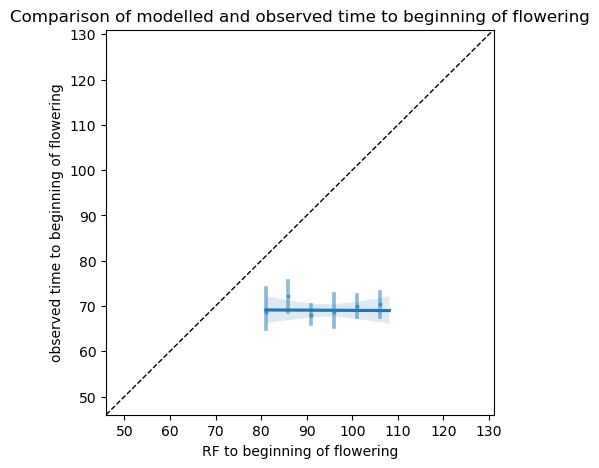

In [98]:
plot_modelled_observed(ds_flowering_KE, phase_list = ['beginning of flowering'])

In [ ]:
test_flowering_no_RS, train_flowering_no_RS = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_no_RS, phase_list = ['beginning of flowering'])

In [73]:
modelled = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\ripeness_model_output_DE.csv')
modelled = modelled.where(modelled['Referenzjahr'] >= 2017).dropna(how='all')
modelled = modelled.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_MODIS_DE.csv')
ds_inputs = pd.merge(modelled[['Stations_Id', 'year', 'observed time to yellow ripeness', 'modelled time to yellow ripeness']],
                    ds_LSP, 
                    on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_ripeness = loc_and_SOS(ds_inputs, predictor_type='savgol').dropna(how='any')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2389603550.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [75]:
modelled = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\flowering_model_output_DE.csv')
modelled = modelled.where(modelled['Referenzjahr'] >= 2017).dropna(how='all')
modelled = modelled.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_MODIS_DE.csv')
ds_inputs = pd.merge(modelled[['Stations_Id', 'year', 'observed time to beginning of flowering', 'modelled time to beginning of flowering']],
                    ds_LSP, 
                    on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_flowering = loc_and_SOS(ds_inputs, predictor_type='savgol').dropna(how='any')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2389603550.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [77]:
ds_ripeness = prepare_frame_for_ML(ds_inputs_ripeness, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'savgol', T_base = 6, cumulative=False, model_output = True)
ds_flowering = prepare_frame_for_ML(ds_inputs_flowering, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'savgol', cumulative=False, model_output = True)
#ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'savgol', cumulative=False)

In [71]:
test_ripeness, train_ripeness = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  ['modelled time to yellow ripeness'] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness, phase_list = ['yellow ripeness'])

R^2 value for model: 0.07635440685449779
Bias: 0.008185941043084807
Variance of modelled values: 11.8250987224158
R^2 value for model: 0.30546820848616374
Bias: 0.793796145124698
Variance of modelled values: 33.09341254355401
R^2 value for model: 0.3173406199407246
Bias: 0.4463512471655076
Variance of modelled values: 29.08443484320558


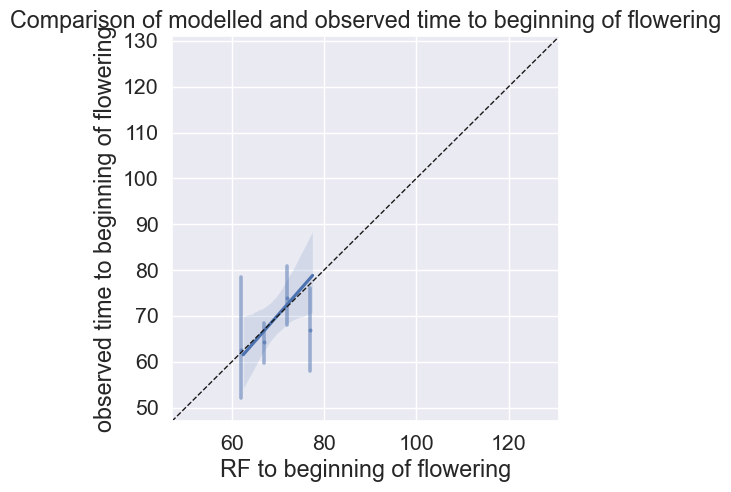

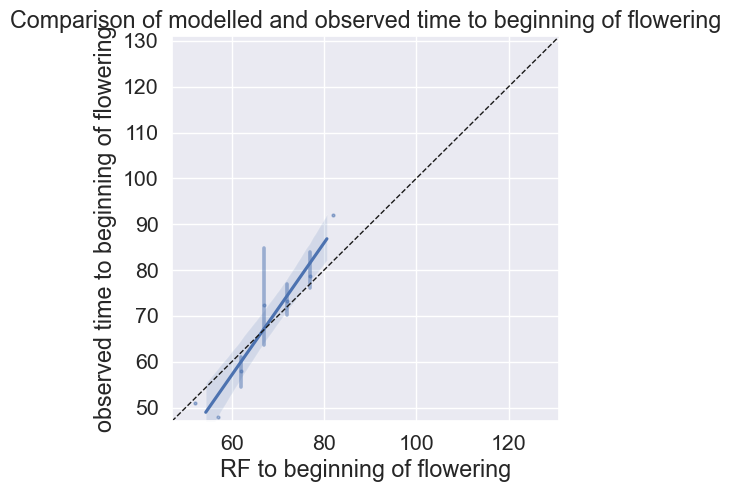

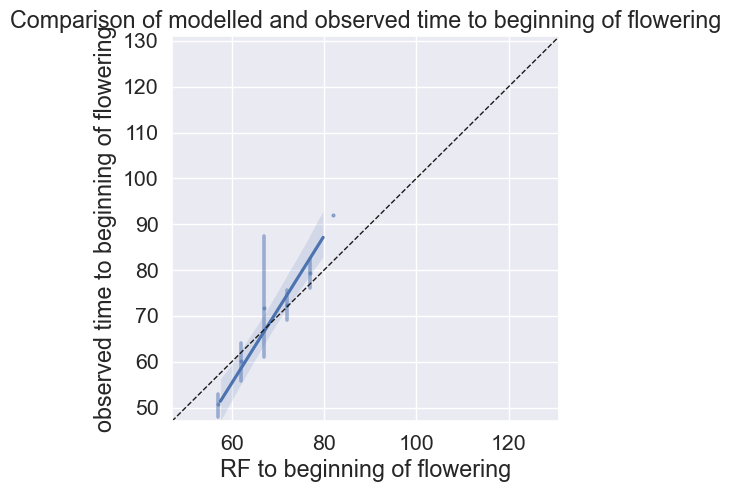

In [133]:
test_flowering, train_flowering, clf_flowering = train_and_run_tree(ds_flowering_KE,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],#,  #['modelled time to beginning of flowering'] 
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])
test_flowering, train_flowering, clf_flowering = train_and_run_tree(ds_flowering_KE,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns = [f'temperature at day {n}' for n in range(200)],#,  #['modelled time to beginning of flowering'] 
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])
test_flowering, train_flowering, clf_flowering = train_and_run_tree(ds_flowering_KE,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns = [f'temperature at day {n}' for n in range(200)]+ ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],#,  #['modelled time to beginning of flowering'] 
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])

In [85]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_MVI_MODIS_DE.csv')
[s for s in ds_LSP.columns if 'interpolated' in s]

['NDVI interpolated at day 04.03',
 'NDVI interpolated at day 04.07',
 'NDVI interpolated at day 04.11',
 'NDVI interpolated at day 04.15',
 'NDVI interpolated at day 04.19',
 'NDVI interpolated at day 04.23',
 'NDVI interpolated at day 04.27',
 'NDVI interpolated at day 05.01',
 'NDVI interpolated at day 05.05',
 'NDVI interpolated at day 05.09',
 'NDVI interpolated at day 05.13',
 'NDVI interpolated at day 05.17',
 'NDVI interpolated at day 05.21',
 'NDVI interpolated at day 05.25',
 'NDVI interpolated at day 05.29',
 'NDVI interpolated at day 06.02',
 'NDVI interpolated at day 06.06',
 'NDVI interpolated at day 06.10',
 'NDVI interpolated at day 06.14',
 'NDVI interpolated at day 06.18',
 'NDVI interpolated at day 06.22',
 'NDVI interpolated at day 06.26',
 'NDVI interpolated at day 06.30',
 'NDVI interpolated at day 07.04',
 'NDVI interpolated at day 07.08',
 'NDVI interpolated at day 07.12',
 'NDVI interpolated at day 07.16',
 'NDVI interpolated at day 07.20',
 'NDVI interpolated 

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\1580758913.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppDa

R^2 value for model: 0.415082145585125
Bias: 1.103382529482336
Variance of modelled values: 99.26970996600879


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3768902733173477
Bias: 1.370604732088902
Variance of modelled values: 110.43678049916586


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.4157568328053889
Bias: 0.21868802873069415
Variance of modelled values: 53.87061537198317


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3915850696570433
Bias: 0.15656147288409192
Variance of modelled values: 56.35464235025906


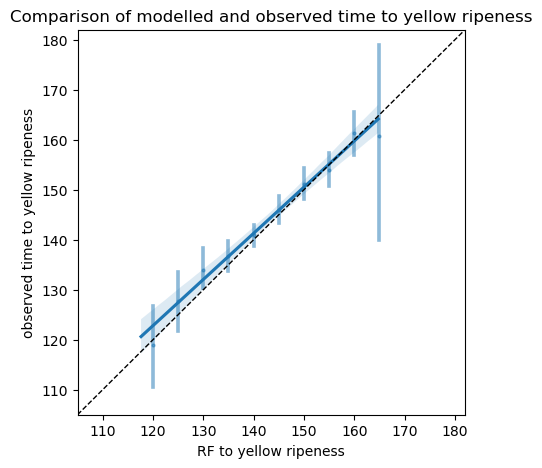

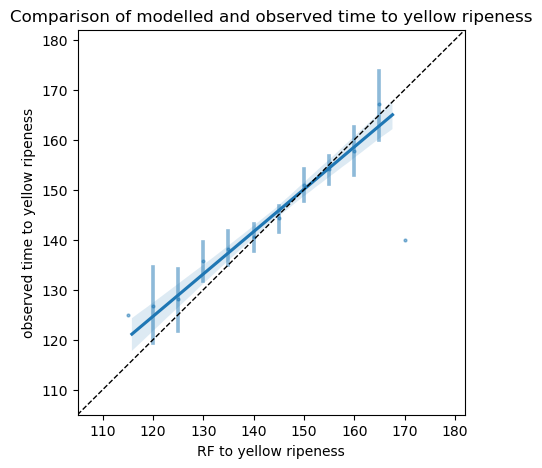

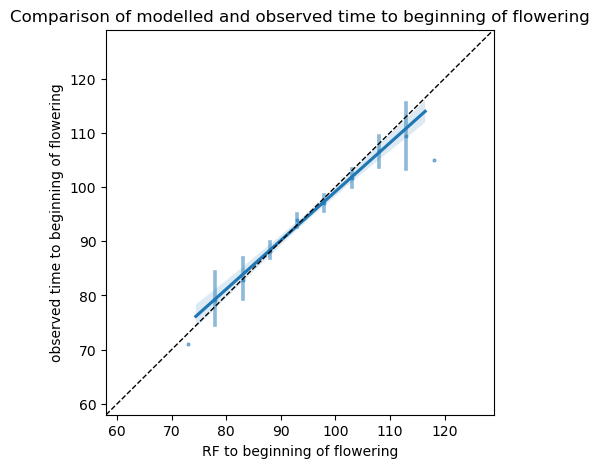

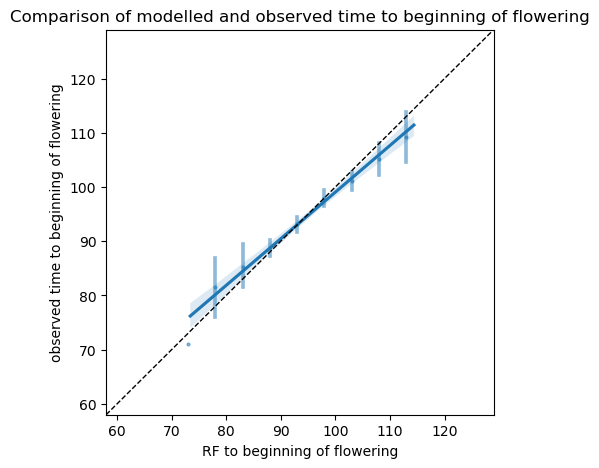

In [99]:
ds_reanalysis = read_reanalysis()
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs = loc_and_SOS(ds_inputs, predictor_type='MVI')
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'MVI', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'MVI')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'MVI')#, cumulative=False)
test_ripeness, train_ripeness = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + [s for s in ds_LSP.columns if 'interpolated' in s],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness, phase_list = ['yellow ripeness'])
test_ripeness_no_RS, train_ripeness_no_RS = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness_no_RS, phase_list = ['yellow ripeness'])
test_flowering, train_flowering = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + [s for s in ds_LSP.columns if 'interpolated' in s],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])
test_flowering_no_RS, train_flowering_no_RS = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_no_RS, phase_list = ['beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\1580758913.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppDa

R^2 value for model: 0.40251611806627086
Bias: 1.358171523511308
Variance of modelled values: 100.75955745129524


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.36403049137301047
Bias: 1.0432018838907715
Variance of modelled values: 110.43671908853443


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.40875829934927665
Bias: 0.18477434285937872
Variance of modelled values: 53.45440585162603


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3884006484865412
Bias: 0.1791463060220284
Variance of modelled values: 56.0304911583582


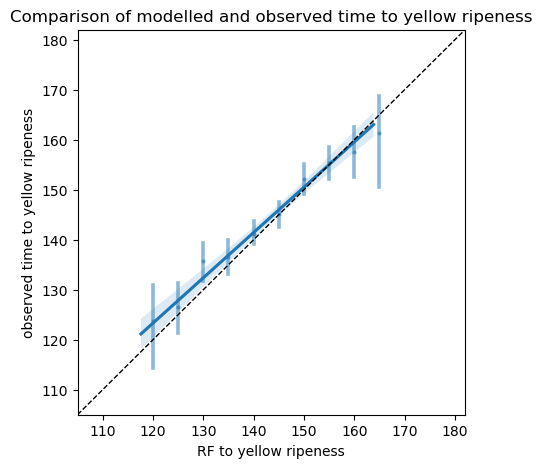

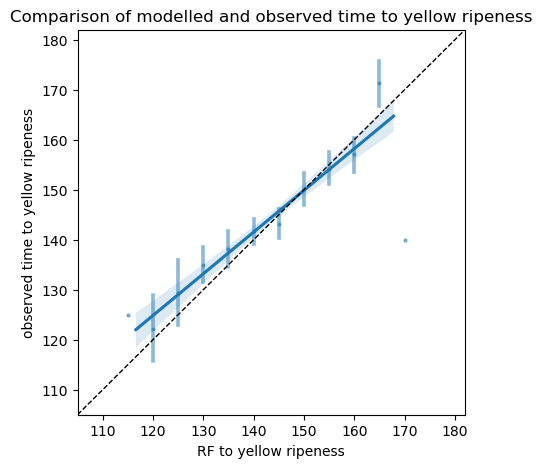

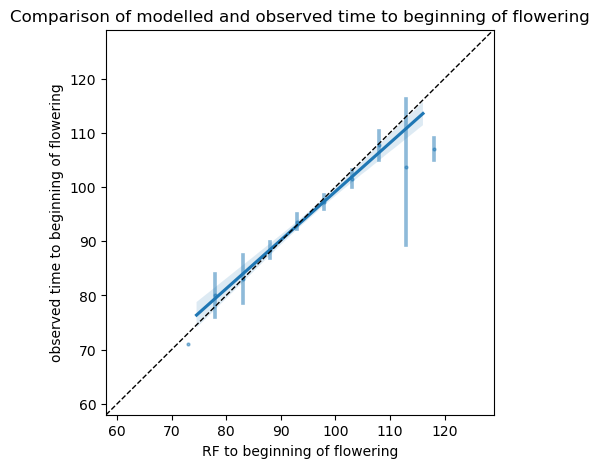

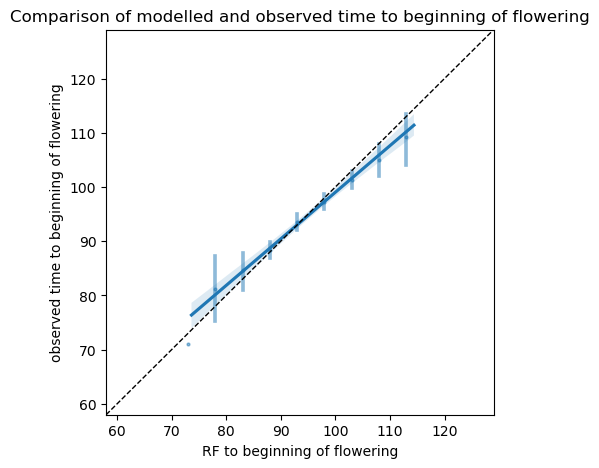

In [92]:
ds_reanalysis = read_reanalysis()
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_MVI_MODIS_DE.csv')
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs = loc_and_SOS(ds_inputs, predictor_type='MVI')
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'MVI', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'MVI')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'MVI')#, cumulative=False)
test_ripeness, train_ripeness = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + [s for s in ds_LSP.columns if 'interpolated' in s],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness, phase_list = ['yellow ripeness'])
test_ripeness_no_RS, train_ripeness_no_RS = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness_no_RS, phase_list = ['yellow ripeness'])
test_flowering, train_flowering = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + [s for s in ds_LSP.columns if 'interpolated' in s],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])
test_flowering_no_RS, train_flowering_no_RS = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_no_RS, phase_list = ['beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\1580758913.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppDa

R^2 value for model: 0.48950288195765046
Bias: 0.04128027870671681
Variance of modelled values: 97.84787114579609


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.4859237274670529
Bias: 0.04279942660283325
Variance of modelled values: 97.13188630429038


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3860604424901348
Bias: 0.005699936726297215
Variance of modelled values: 50.53464540031566


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_8128\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.3718661396647317
Bias: 0.016021677054461215
Variance of modelled values: 54.46521909792007


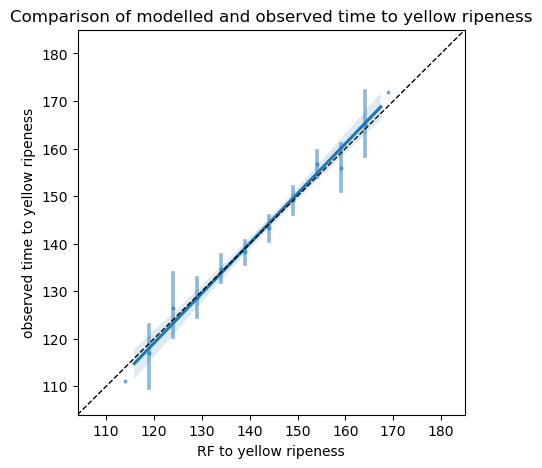

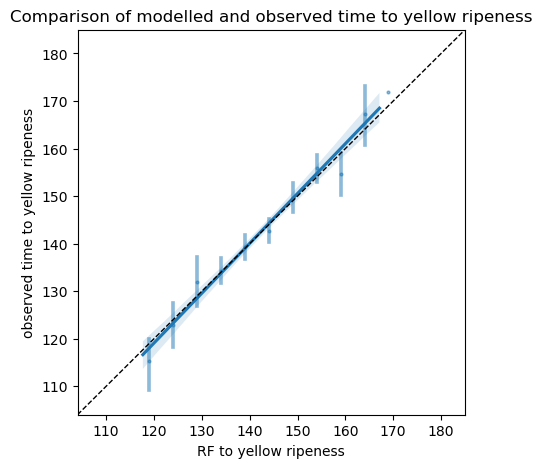

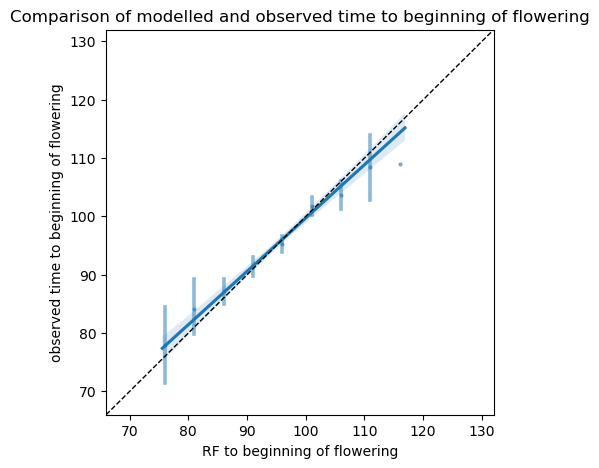

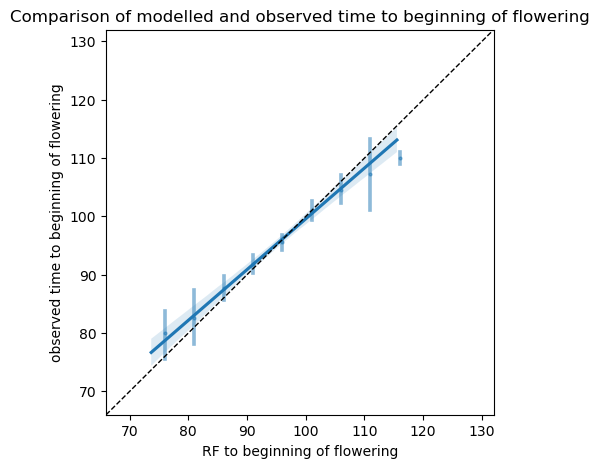

In [93]:
ds_reanalysis = read_reanalysis()
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_MODIS_DE.csv')
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs = loc_and_SOS(ds_inputs, predictor_type='savgol')
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'savgol', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'savgol')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'savgol')#, cumulative=False)
test_ripeness, train_ripeness = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness, phase_list = ['yellow ripeness'])
test_ripeness_no_RS, train_ripeness_no_RS = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to yellow ripeness'])
plot_modelled_observed(test_ripeness_no_RS, phase_list = ['yellow ripeness'])
test_flowering, train_flowering = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile'],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])
test_flowering_no_RS, train_flowering_no_RS = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to beginning of flowering'])
plot_modelled_observed(test_flowering_no_RS, phase_list = ['beginning of flowering'])

In [72]:
def plot_LSP_observed(ds, phases = ['yellow ripeness'], predictor_type = 'percentiles'):
    fig, axes = plt.subplots(1, 6, figsize = (20, 5))
    fig.tight_layout()
    if predictor_type == 'percentiles':
        predictors = ['first time crossing percentile 30%', 'first time crossing percentile 63%', 'first time crossing percentile 93%', 
                    'last time crossing percentile 30%', 'last time crossing percentile 63%', 'last time crossing percentile 93%']
    else:
        predictors = ['minday', 'maxday', 'mingrad', 'maxgrad', 'second last 75 percentile', 'last 75 percentile']
    #predictors = ['first time crossing threshold 15%', 'first time crossing threshold 50%', 'first time crossing threshold 90%', 
    #                'last time crossing threshold 15%', 'last time crossing threshold 50%', 'last time crossing threshold 90%']
    observed_variables = [f'observed time to {phase}' for phase in phases]
    for predictor_index, predictor in enumerate(predictors):
        if predictor == 'second last 75 percentile' or predictor == 'last 75 percentile':
            ds_no_outliers = ds.where(ds[predictor] > 0).dropna(how='all')
        elif predictor == 'mingrad' or predictor == 'maxgrad':
            ds_no_outliers = ds#.where(ds['mingrad'] > ds['maxgrad']).dropna(how='all')
            if predictor == 'mingrad':
                ds_no_outliers = ds_no_outliers#.where((ds_no_outliers[predictor] > 50)).dropna(how='all')
            elif predictor == 'maxgrad':
                ds_no_outliers = ds_no_outliers#.where(ds_no_outliers[predictor] < 150).dropna(how='all')
        elif predictor == 'maxday':
            ds_no_outliers = ds#.where((ds[predictor] < 150)*(ds[predictor] > 50)).dropna(how='all')
        else:
            if predictor_type == 'percentiles':
                ds_no_outliers = ds.where(ds[predictor] > 0).dropna(how='all')
        for observed_variable_index, observed_variable in enumerate(observed_variables):
            minval = min(ds_no_outliers[predictor].min(), ds_no_outliers[observed_variable].min()) - 1
            maxval = max(ds_no_outliers[predictor].max(), ds_no_outliers[observed_variable].max()) + 1
            axs = axes[predictor_index]#, observed_variable_index
            sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axs,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
            axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)

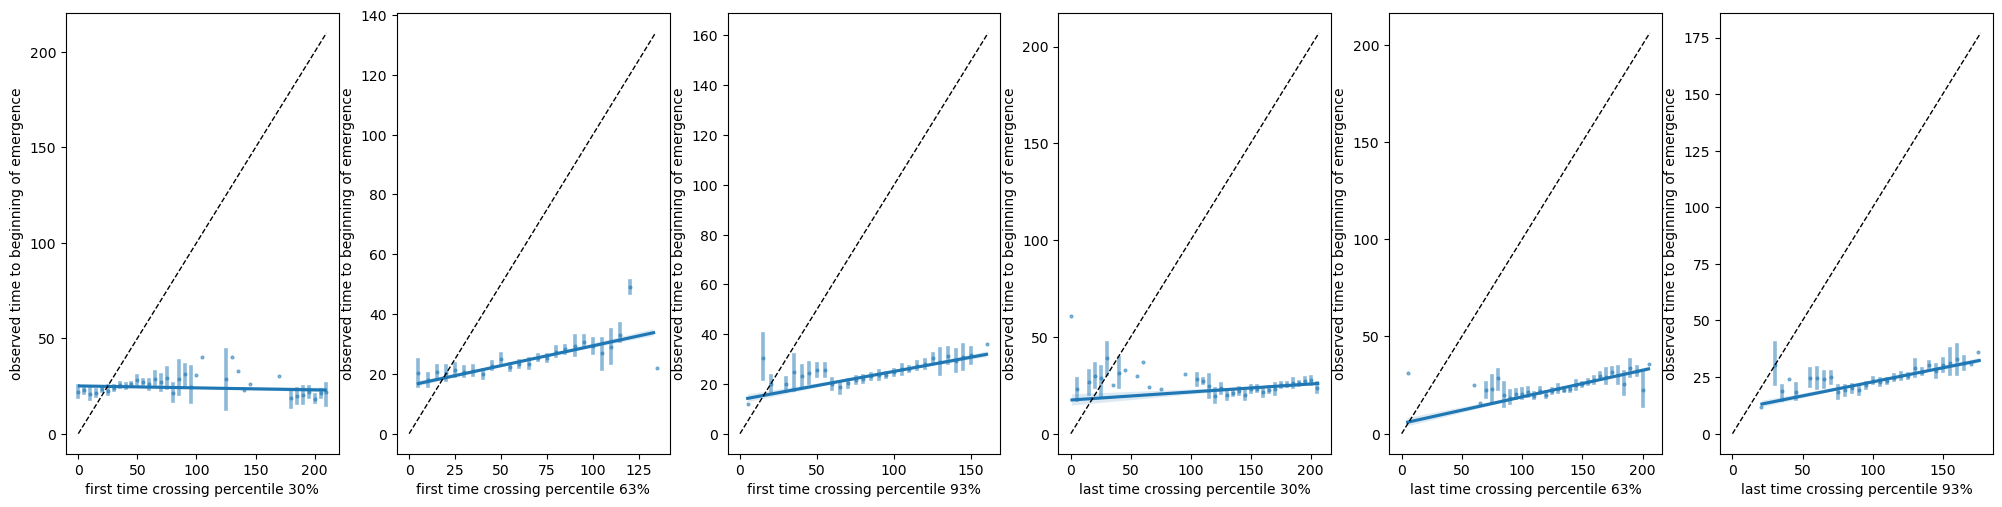

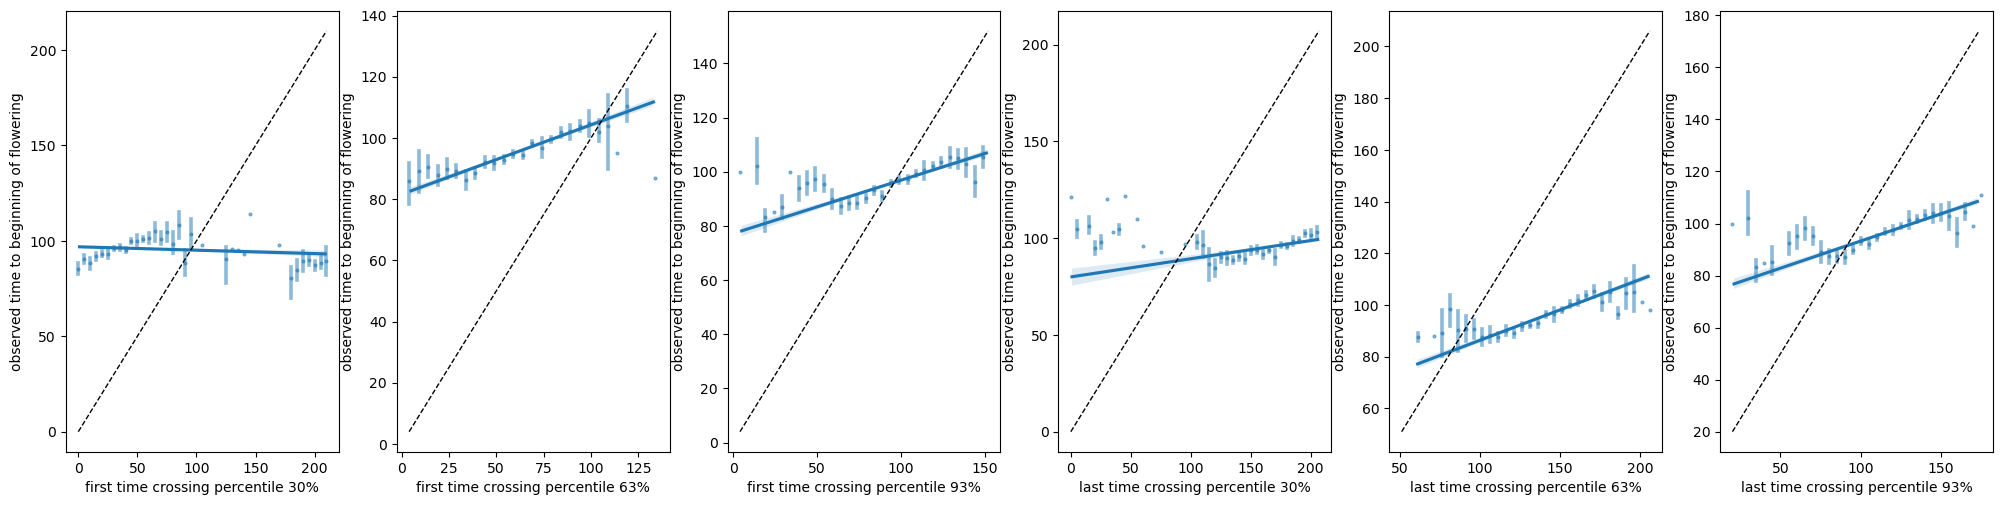

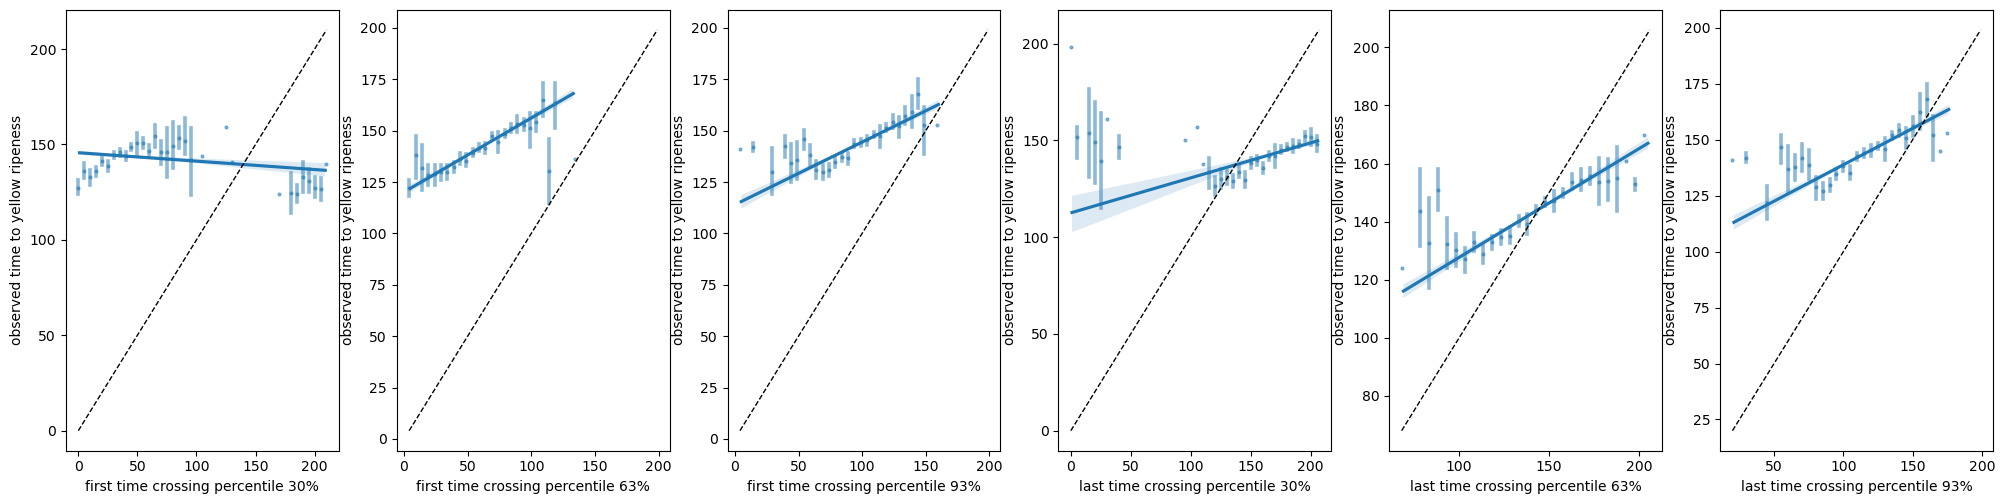

In [73]:
plot_LSP_observed(ds_emergence_DE, phases = ['beginning of emergence'])
plot_LSP_observed(ds_flowering_DE, phases = ['beginning of flowering'])
plot_LSP_observed(ds_ripeness_DE, phases = ['yellow ripeness'])

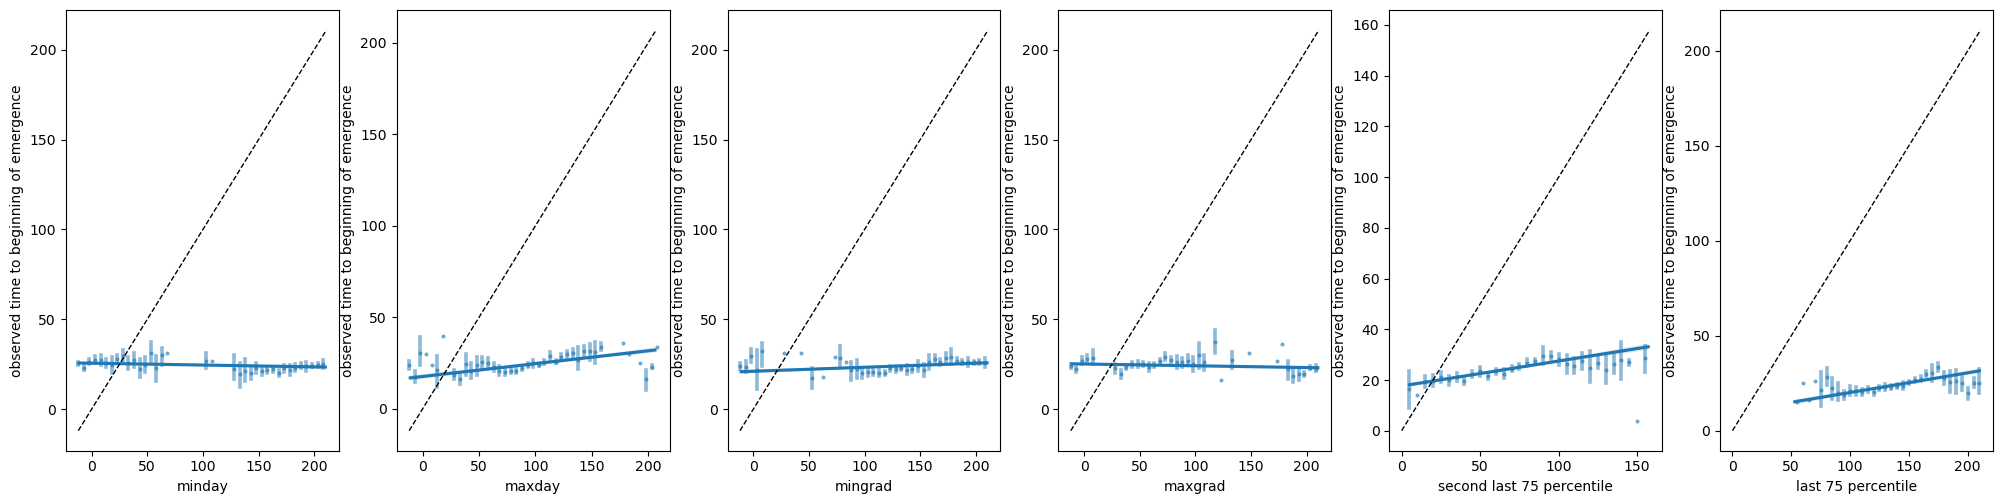

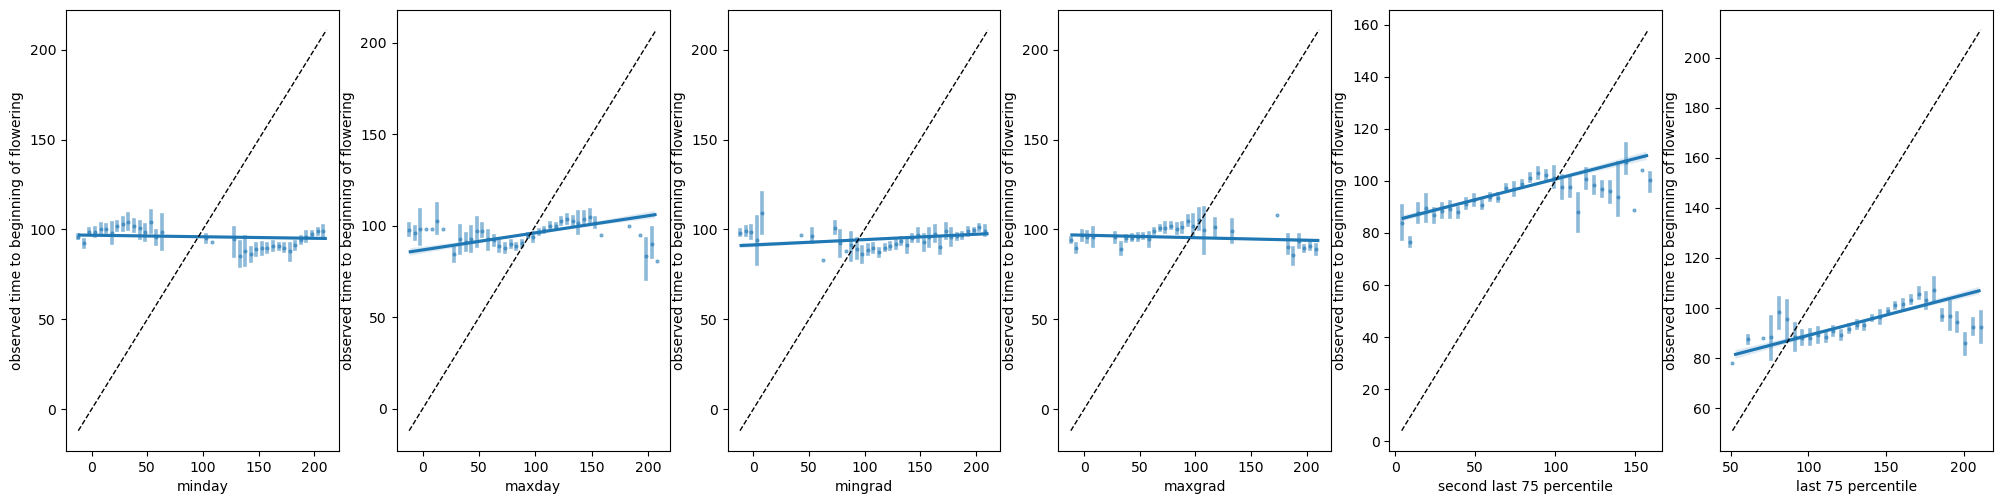

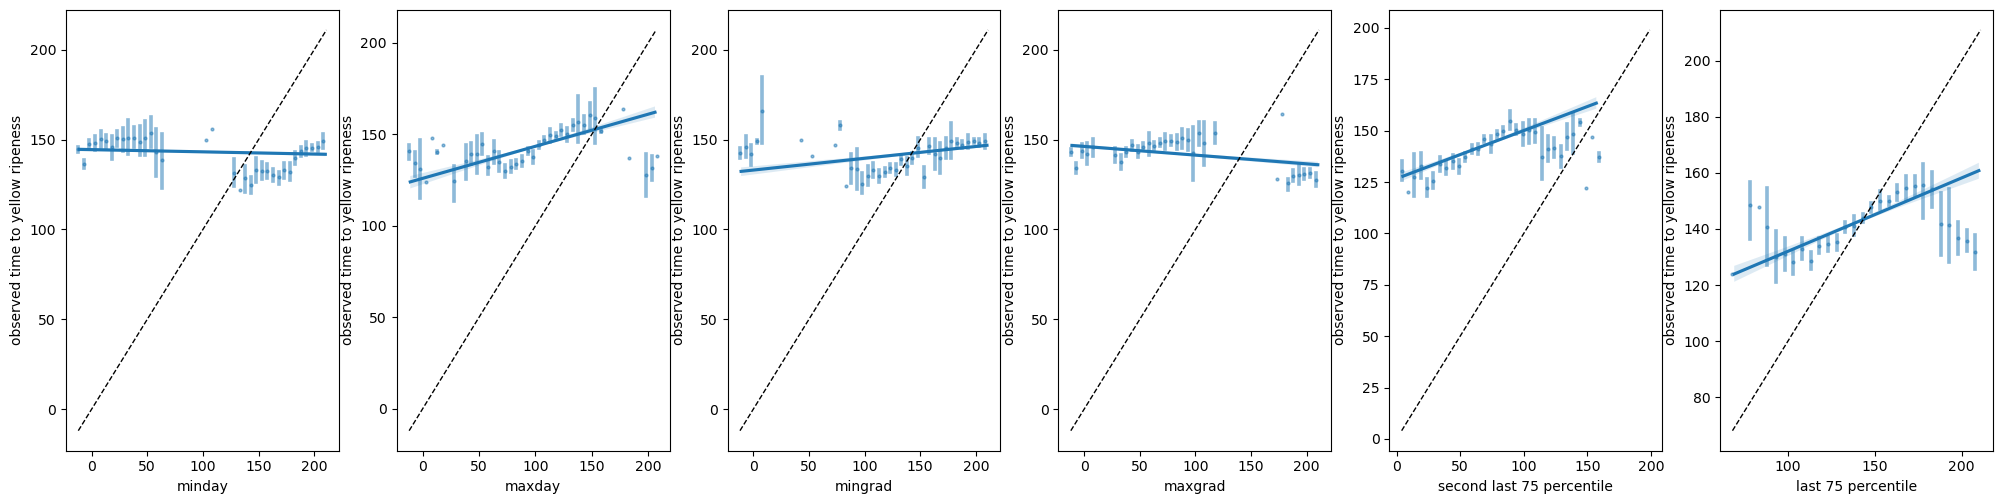

In [51]:
plot_LSP_observed(ds_emergence, phases = ['beginning of emergence'])
plot_LSP_observed(ds_flowering, phases = ['beginning of flowering'])
plot_LSP_observed(ds_ripeness, phases = ['yellow ripeness'])

In [24]:
def combine_columns(ds):
    list_of_arrays = []
    for day_index in range(200):
        day_array = ds[['year', 'Stations_id', 'lat', 'lon', 'SOS', 'WC SOS date', f'linterp day {day_index}', f't2m at day {day_index}']].set_index(['Stations_id', 'year']).to_xarray()
        day_array = day_array.rename({f'linterp day {day_index}': 'linterp', f't2m at day {day_index}': 't2m'})
        day_array = day_array.expand_dims('time')
        day_array = day_array.assign_coords(time=("time", [day_index]))
        list_of_arrays.append(day_array)
    return xr.concat(list_of_arrays, dim='time')
#ripeness_array#.expand_dims(dim={'time':200})
#ripeness

def MVI_array(da, index_variable = 'time', response_variable = 'linterp', bins = np.arange(0, 201, 10), original_length = 1):
    binned = da.groupby_bins(index_variable, bins, labels = bins[:-1])
    maxs = binned.max()
    max_locs = binned.map(lambda arr: np.argmax(arr))
    max_locs[index_variable] = max_locs[f'{index_variable}_bins'] + max_locs[response_variable]*original_length
    maxs['MVI NDVI'] = ((f'{index_variable}_bins'), np.interp(maxs[f'{index_variable}_bins'], max_locs[index_variable], maxs[response_variable]))
    return maxs

def to_temp_coords(da, new_coords = np.arange(0, 1701, 10)):
    da['time_index'] = da['time']#
    temps_maxed = da.groupby('t2m').max().set_coords('time_index')
    temps_interpolated = temps_maxed.interp(t2m=new_coords, kwargs={"fill_value": 0})
    return temps_interpolated

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim

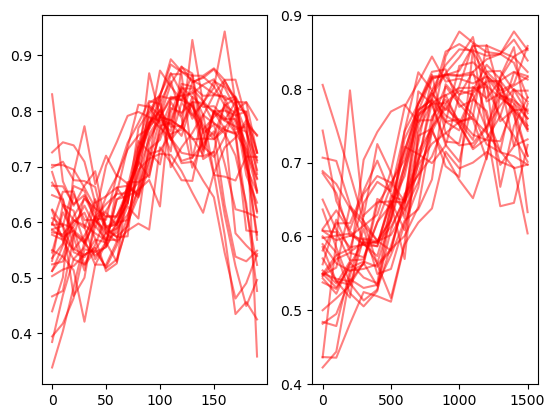

In [299]:
fig, axs = plt.subplots(1, 2)
for statid in ripeness_array['Stations_id'].values[:10]:
    for year in ripeness_array['year'].values:
        ripeness_array_at_year = ripeness_array.sel(Stations_id = statid, year = year)
        if np.isnan(ripeness_array_at_year['t2m'].isel(time = 0)):
            continue
        time_binned = ripeness_array_at_year.groupby_bins('time', np.arange(0, 201, 10), labels = np.arange(0, 191, 10))
        maxs = MVI_array(ripeness_array_at_year, index_variable = 'time', response_variable = 'linterp', bins = np.arange(0, 201, 10), original_length = 1)
        axs[0].plot(maxs['time_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        temps_interpolated = to_temp_coords(ripeness_array_at_year, new_coords = np.arange(0, 1601, 10))
        maxs = MVI_array(temps_interpolated, index_variable = 't2m', response_variable = 'linterp', bins = np.arange(0, 1601, 100), original_length = 10)
        axs[1].plot(maxs['t2m_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)

In [62]:
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m', 'd2m', 'ssrd', 'tp'], numdays = 200, predictor_type = 'thresholds')
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m', 'd2m', 'ssrd', 'tp'], numdays = 200, predictor_type = 'thresholds')
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m', 'd2m', 'ssrd', 'tp'], numdays = 200, predictor_type = 'thresholds')
#ds_flowering = ds_flowering.where(ds_flowering['second last 75 percentile'] > 0).dropna()
#ds_ripeness = ds_ripeness.where(ds_ripeness['second last 75 percentile'] > 0).dropna()

In [27]:
def correlations_for_phase(ds, phases = ['beginning of flowering']):
    corrs = ds[[f'observed time to {phase}' for phase in phases] + [f'first time crossing threshold {int(percentage)}%' for percentage in np.arange(0, 100)] + [f'last time crossing threshold {int(percentage)}%' for percentage in np.arange(0, 100)]].corr()[[f'observed time to {phase}' for phase in phases]+ ['first time crossing threshold 99%']]
    corrs = corrs.drop([f'observed time to {phase}' for phase in phases])
    return corrs

In [28]:
def correlations_for_phase(ds, phases = ['beginning of flowering']):
    for percentage in range(100):
        ds = ds.where(ds[f'first time crossing percentile {int(percentage)}%']>0).dropna(how = 'any')
    corrs = ds[[f'observed time to {phase}' for phase in phases] + [f'first time crossing percentile {int(percentage)}%' for percentage in np.arange(0, 100)] + [f'last time crossing percentile {int(percentage)}%' for percentage in np.arange(0, 100)]].corr()[[f'observed time to {phase}' for phase in phases]+ ['first time crossing percentile 99%']]
    corrs = corrs.drop([f'observed time to {phase}' for phase in phases])
    return corrs

In [47]:
def bias_for_phase(ds, phases = ['beginning of flowering']):
    for percentage in range(100):
        ds = ds.where(ds[f'first time crossing percentile {int(percentage)}%']>0).dropna(how = 'any')
    ds_bias_list = []
    for phase in phases:
        phase_bias = ds[[f'first time crossing percentile {int(percentage)}%' for percentage in np.arange(0, 100)] + [f'last time crossing percentile {int(percentage)}%' for percentage in np.arange(0, 100)]].mean() - ds[f'observed time to {phase}'].mean()
        ds_bias_list.append(phase_bias)
    return ds_bias_list

Text(0.5, 1.0, 'Distribution of discrepancy between max NDVI date and anthesis')

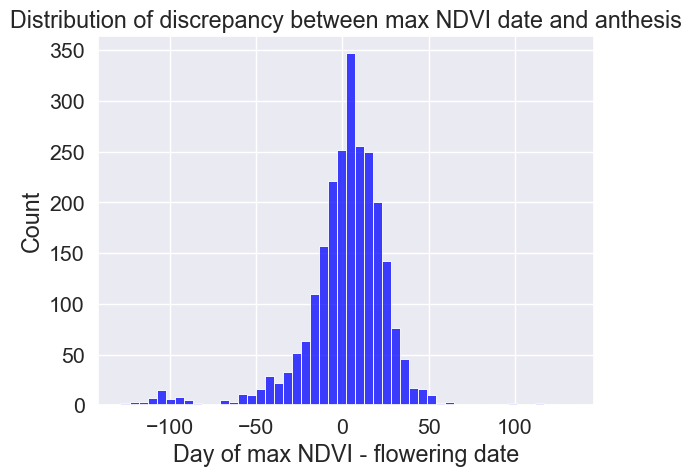

In [106]:
ds_flowering_DE_savgol['Day of max NDVI - flowering date'] = ds_flowering_DE_savgol['maxday'] - ds_flowering_DE_savgol['observed time to beginning of flowering']
sns.set(font_scale=1.4)
fig, axs = plt.subplots()
sns.histplot(data=ds_flowering_DE_savgol, x='Day of max NDVI - flowering date', ax=axs, bins =50, color='blue', label = 'planting')
axs.set_title('Distribution of discrepancy between max NDVI date and anthesis')

In [101]:
ds_flowering_DE_savgol['LSP_error'].mean()

1.5907015359070154

<Axes: xlabel='first time crossing percentile 80%', ylabel='Count'>

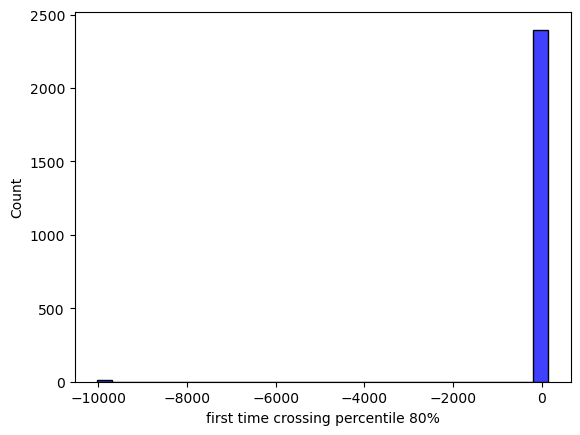

In [46]:
ds_flowering_DE_savgol['LSP_error'] = ds_flowering_DE_savgol['maxday'] - ds_flowering_DE_savgol['observed time to beginning of flowering']
sns.histplot(data=ds_flowering_DE, x="first time crossing percentile 80%", bins =30, color='blue', label = 'planting')

In [89]:
bias_flowering = bias_for_phase(ds_flowering_DE, phases = ['beginning of flowering'])
#ds_ripeness_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_ripeness_DE['observed time to beginning of flowering']).dt.days
#ds_ripeness_DE = ds_ripeness_DE.loc[ds_ripeness_DE['observed time to beginning of flowering'] > 0].dropna(subset = ['observed time to beginning of flowering'])
bias_ripeness = bias_for_phase(ds_ripeness_DE, phases = ['yellow ripeness'])
bias_emergence = bias_for_phase(ds_emergence_DE, phases = ['beginning of emergence'])

In [16]:
ds_flowering_reduced = ds_flowering.sample(frac=0.5)#.where(ds_flowering['first time crossing threshold 50%'] > 16).sample(frac=0.5)
ds_emergence_reduced = ds_emergence.sample(frac=0.5)#.where(ds_emergence['first time crossing threshold 50%'] > 16).sample(frac=0.5)
ds_ripeness_reduced = ds_ripeness.sample(frac=0.5)#.where(ds_ripeness['first time crossing threshold 50%'] > 16).sample(frac=0.5)

In [17]:
corrs_flowering = correlations_for_phase(ds_flowering_reduced, phases=['beginning of flowering'])
corrs_emergence = correlations_for_phase(ds_emergence_reduced, phases=['beginning of emergence'])
corrs_ripeness = correlations_for_phase(ds_ripeness_reduced, phases=['yellow ripeness'])

In [29]:
def plot_corrs(corr_ds, phase):
    fig, axs = plt.subplots()
    axs.plot(np.arange(0, 100), corr_ds[f'observed time to {phase}'][:100], label = 'first time at this threshold')
    axs.plot(np.arange(0, 100), corr_ds[f'observed time to {phase}'][100:], label = 'last time at this threshold')
    fig.legend()

In [63]:
def plot_bias(bias_ds, phase):
    fig, axs = plt.subplots()
    axs.plot(np.arange(0, 100), bias_ds[[f'first time crossing percentile {percent}%' for percent in range(100)]].values, label = 'first time at this threshold')
    axs.plot(np.arange(0, 100),  bias_ds[[f'last time crossing percentile {percent}%' for percent in range(100)]].values, label = 'last time at this threshold')
    axs.set_ylim(-100, 100)
    axs.set_xlim(40, 101)
    axs.axhline(0, linestyle = '--', color = 'k')
    fig.legend()

In [87]:
bias_ripeness[0]

first time crossing percentile 0%   NaN
first time crossing percentile 1%   NaN
first time crossing percentile 2%   NaN
first time crossing percentile 3%   NaN
first time crossing percentile 4%   NaN
                                     ..
last time crossing percentile 95%   NaN
last time crossing percentile 96%   NaN
last time crossing percentile 97%   NaN
last time crossing percentile 98%   NaN
last time crossing percentile 99%   NaN
Length: 200, dtype: float64

In [64]:
print(bias_flowering[0][[f'first time crossing percentile {percent}%' for percent in range(50)] + [f'last time crossing percentile {percent}%' for percent in range(50)]].abs().idxmin(),
        bias_ripeness[0][[f'first time crossing percentile {percent}%' for percent in range(50)] + [f'last time crossing percentile {percent}%' for percent in range(50)]].abs().idxmin())

last time crossing percentile 14% last time crossing percentile 24%


In [97]:
bias_flowering[0].abs().idxmin()

'first time crossing percentile 93%'

In [66]:
bias_ripeness[0].abs().idxmin()

'last time crossing percentile 63%'

In [107]:
def plot_one_predictor(ds, predictor = 'last time crossing percentile 63%', phase = 'beginning of flowering'):
    observed_variable = f'observed time to {phase}'
    fig, axs = plt.subplots(figsize = (5, 5))
    ds_no_outliers = ds.where(ds[predictor] > 0).dropna(how='all')
    minval = min(ds_no_outliers[predictor].min(), ds_no_outliers[observed_variable].min()) - 1
    maxval = max(ds_no_outliers[predictor].max(), ds_no_outliers[observed_variable].max()) + 1
    sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axs,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
    axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
    axs.set_title(f'{predictor}\ncompared to\nobserved time to {phase}')

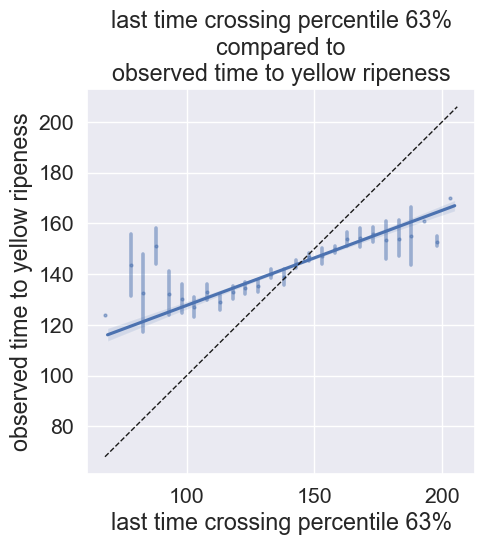

In [108]:
plot_one_predictor(ds_ripeness_DE, phase = 'yellow ripeness')

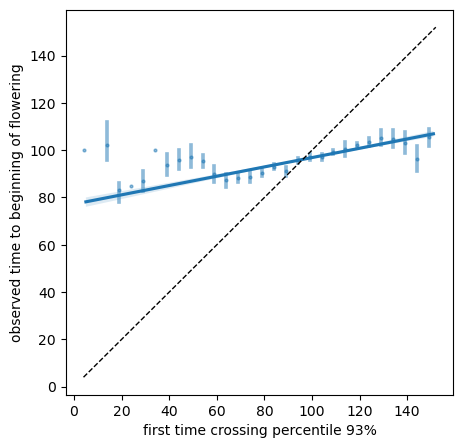

In [95]:
plot_one_predictor(ds_flowering_DE, predictor = 'first time crossing percentile 93%',)

In [80]:
ds_ripeness_DE['observed time to beginning of flowering']

18            NaN
19        94 days
20       104 days
21       106 days
22       106 days
           ...   
21532    102 days
21533    101 days
21551     93 days
21618    100 days
21620    122 days
Name: observed time to beginning of flowering, Length: 1794, dtype: object

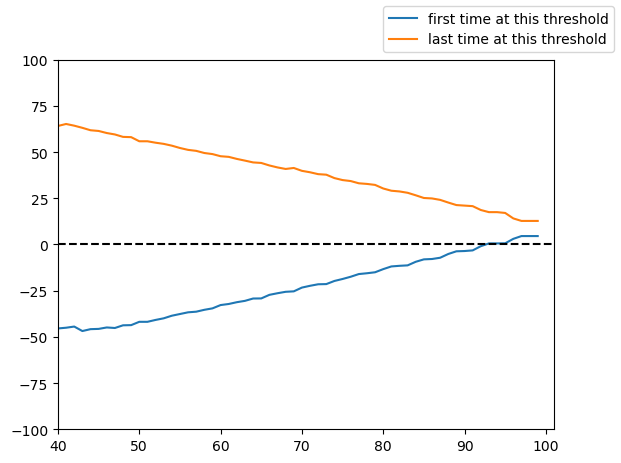

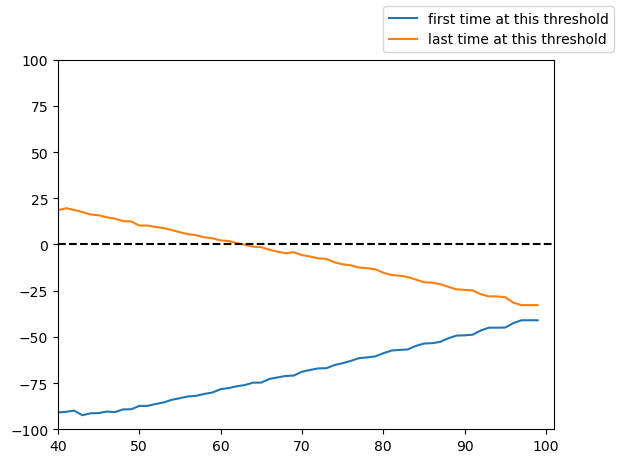

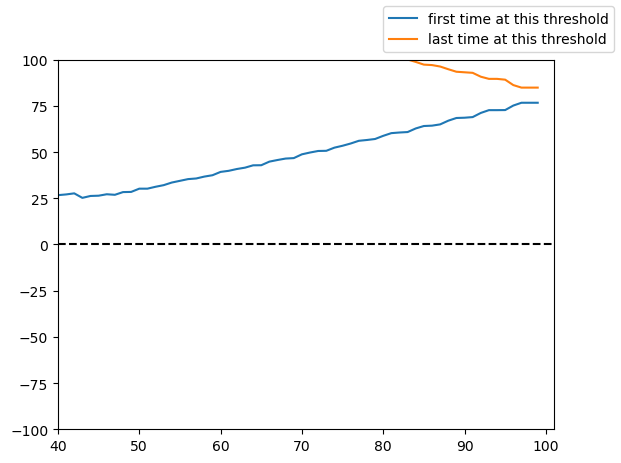

In [92]:
plot_bias(bias_flowering[0], 'beginning of flowering')
plot_bias(bias_ripeness[0], 'yellow ripeness')
plot_bias(bias_emergence[0], 'beginning of emergence')

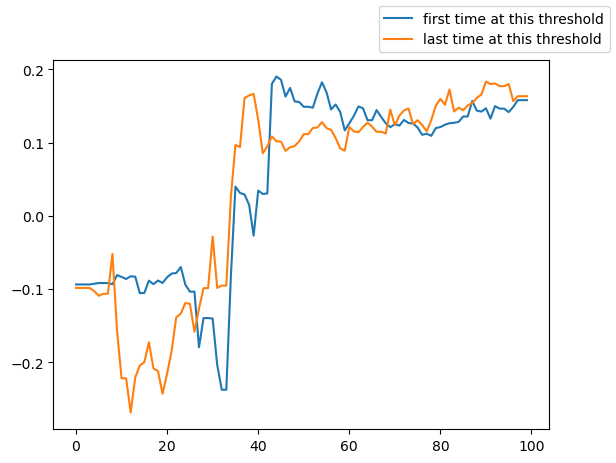

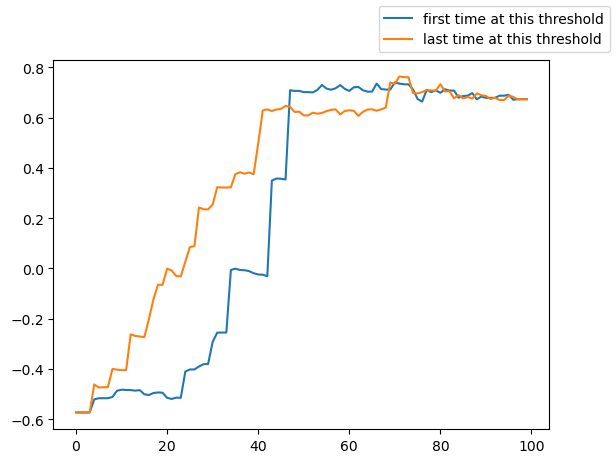

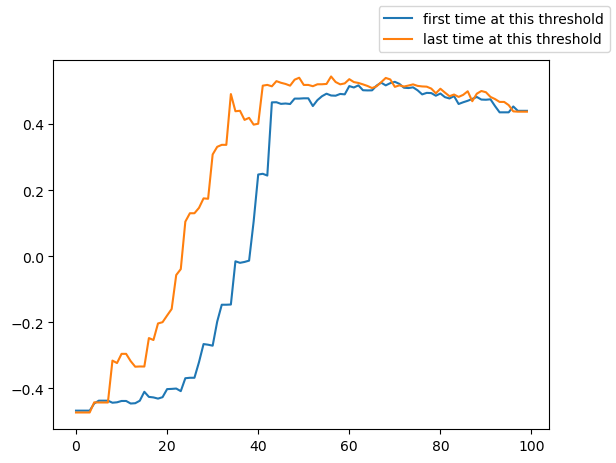

In [19]:
plot_corrs(corrs_emergence, 'beginning of emergence')
plot_corrs(corrs_flowering, 'beginning of flowering')
plot_corrs(corrs_ripeness, 'yellow ripeness')

In [31]:
test_ripeness_reduced, train_ripeness_reduced = train_and_run_tree(ds_ripeness_reduced,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday','maxday', 'second last 75 percentile', 'last 75 percentile'], #'mingrad', 'maxgrad', 'minday', 
                                                     response_columns =['observed time to yellow ripeness'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.2533865461480902
Bias: 0.0005885897920601764
Variance of modelled values: 68.7672139679236


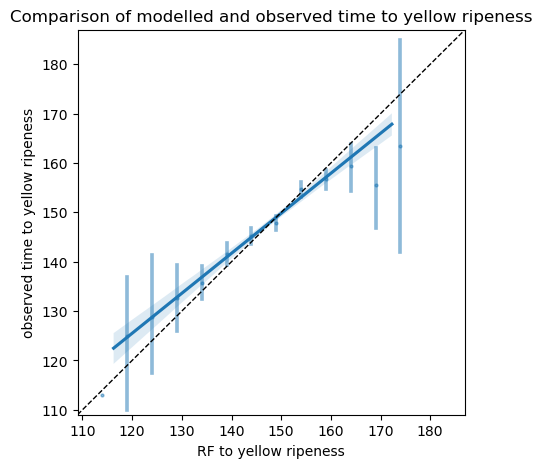

In [32]:
plot_modelled_observed(test_ripeness_reduced, phase_list = ['yellow ripeness'])

In [36]:
test_flowering_reduced, train_flowering_reduced = train_and_run_tree(ds_flowering_reduced,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  ['mingrad', 'maxgrad', 'minday','maxday', 'second last 75 percentile', 'last 75 percentile'], #[f't2m at day {n}' for n in range(200)] + 'mingrad', 'maxgrad', 'minday', 
                                                     response_columns =['observed time to beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: -0.028336659912550077
Bias: 0.010633644730622213
Variance of modelled values: 11.766495007687931


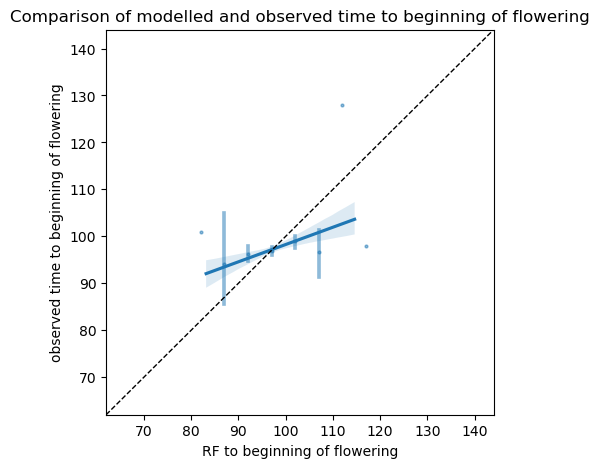

In [37]:
plot_modelled_observed(test_flowering_reduced, phase_list = ['beginning of flowering'])

In [21]:
test_flowering_no_RS, train_flowering_no_RS = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.32811404125241583
Bias: 0.0010254803033846636
Variance of modelled values: 51.6980812767027


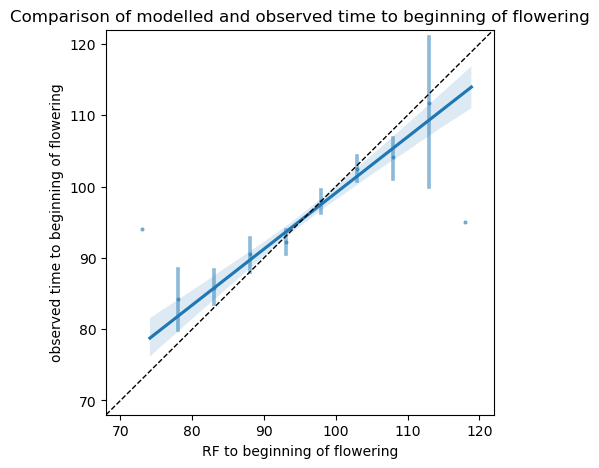

In [23]:
plot_modelled_observed(test_flowering_no_RS, phase_list = ['beginning of flowering'])

In [19]:
test_flowering, train_flowering = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile'],
                                                     response_columns =['observed time to beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.4274878662082797
Bias: 0.2370226410838794
Variance of modelled values: 49.80119564128337


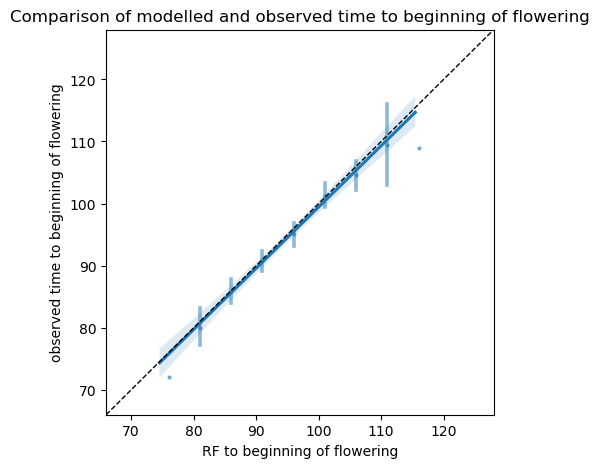

In [20]:
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])

In [30]:
test_ripeness_no_RS, train_ripeness_no_RS = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to yellow ripeness'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.41503697995295885
Bias: 0.10064526360006716
Variance of modelled values: 111.72566371755995


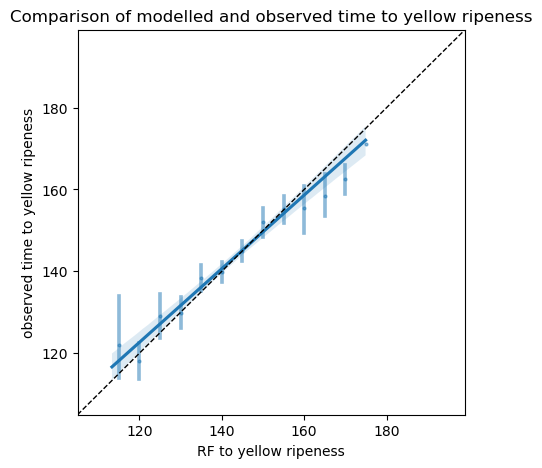

In [31]:
plot_modelled_observed(test_ripeness_no_RS, phase_list = ['yellow ripeness'])

In [32]:
test_ripeness, train_ripeness = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile'],
                                                     response_columns =['observed time to yellow ripeness'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.4311816142199918
Bias: 0.15212260953579806
Variance of modelled values: 109.86026697337375


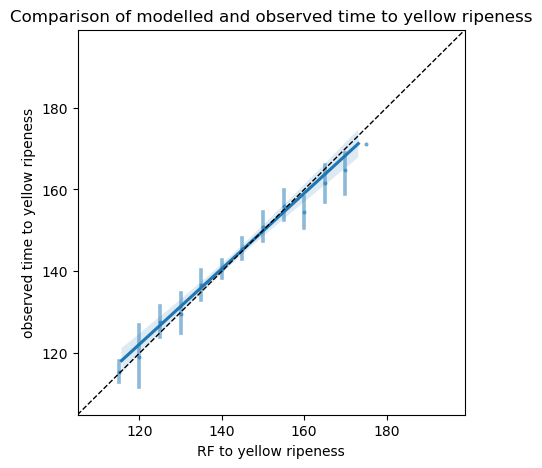

In [33]:
plot_modelled_observed(test_ripeness, phase_list = ['yellow ripeness'])

In [49]:
def permutation_importance_all_vars(ds, training_columns, response_columns, clf_fit):
    X_eval = ds[training_columns].values
    y_eval = ds[response_columns].values

    r = permutation_importance(clf_fit, X_eval, y_eval,
                            n_repeats=30,
                            random_state=0)

    for i in r.importances_mean.argsort()[::-1]:
        #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{training_columns[i]:<15}",
                f"{r.importances_mean[i]:.3f}",
                f" +/- {r.importances_std[i]:.3f}")

In [39]:
ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')
ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_d2m.csv')
ds_d2m = ds_d2m.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ssrd.csv')
ds_ssrd = ds_ssrd.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_tp.csv')
ds_tp = ds_tp.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_reanalysis1 = pd.merge(ds_t2m, ds_d2m, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
ds_reanalysis2 = pd.merge(ds_ssrd, ds_tp, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
ds_reanalysis = pd.merge(ds_reanalysis1, ds_reanalysis2, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
print('Should be all the same if it worked: ', len(ds_reanalysis), len(ds_ssrd), len(ds_tp), len(ds_d2m))

Should be all the same if it worked:  4914 4914 4914 4914


In [65]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
#ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to yellow ripeness', 'emergence date', 't2m day 0'])
ds = ds.where(ds['observed time to yellow ripeness'] > 0).dropna(how='all')
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 't2m', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'tp', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'ssrd', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'd2m', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
#ds = ds.where((ds['last 75 percentile'] < 275)*(ds['last 75 percentile'] > 200)).dropna(how='all')
#ds = ds.where(ds['maxgrad'] < ds['mingrad']).dropna(how='all')
thinning_num = 40

In [74]:
training_columns =  [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'ssrd day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #+[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] +  [f'tp day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness'] +[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + ['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile'] #['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile']##+ ['mingrad', 'maxgrad', 'last 75 percentile'] ['mingrad', 'maxgrad', 'last 75 percentile'] #+   ##
response_columns =['observed time to yellow ripeness']# ['observed time emergence to beginning of flowering', 'emergence date']#['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']#['observed time emergence to yellow ripeness']#
ds2 = ds.dropna(subset = training_columns + response_columns).reset_index()
training, verification = subsample(ds2, subsample_frac = 0.9)

In [77]:
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values

r = permutation_importance(clf_fit, X_eval, y_eval,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{training_columns[i]:<15}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

d2m day 40      0.308  +/- 0.058
ssrd day 40     0.012  +/- 0.022
d2m day 120     0.002  +/- 0.018
ssrd day 160    0.000  +/- 0.014
ssrd day 80     -0.003  +/- 0.013
d2m day 80      -0.008  +/- 0.010
d2m day 160     -0.012  +/- 0.016
ssrd day 120    -0.017  +/- 0.017
d2m day 0       -0.023  +/- 0.010
ssrd day 0      -0.034  +/- 0.016


In [ ]:
import requests
full_catalog_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images/catalog.json'
full_catalog_info = requests.get(full_catalog_url)
first = True
for location_info in full_catalog_info.json()['links'][2:3]:
    labels = []
    if location_info['rel'] == 'child':
        location_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images' + location_info['href'][1:]
        catalog_info = requests.get(location_url)
        print(catalog_info.json()['id'])
        image_links = catalog_info.json()['links']
        locs = catalog_info.json()['extent']['spatial']['bbox'][0]
        for index, infos in enumerate(image_links):
            #print(index)
            image_info_location = infos['href']
            image_info = requests.get(image_info_location)
            if 'assets' in image_info.json().keys():
                image_label_location = image_info.json()['assets']['label']['href']
                image_label = requests.get(image_label_location).json()
                labels.append(image_label[0])
        dataframe_to_add = pd.DataFrame(labels)
        dataframe_to_add['west'] = locs[0]
        dataframe_to_add['south'] = locs[1]
        dataframe_to_add['east'] = locs[2]
        dataframe_to_add['north'] = locs[3]
        if first:
            phen_data = dataframe_to_add
            first = False
        else:
            phen_data = pd.concat([phen_data, dataframe_to_add])
for index, record in phen_data.iterrows():
    if record['growth_stage'] == 'V':
        filename = record['filename']
        print(filename)
        print(f'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/images/{filename}')
print(phen_data['growth_stage'].unique())